## Imports

In [1]:
import json, os, sys
import pickle, csv
import time
import datetime
from collections import OrderedDict
import itertools
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px

import scipy
import librosa
from IPython.display import Audio as ipy_audio

In [2]:
from quicktranscribe import tonic, pitch, wave

## Data

In [ ]:
data_dir = "/Users/neerajaabhyankar/Repos/icm-shruti-analysis/data-dunya-hindustani/"
track = "Omkar Dadarkar - Raag Bhoopali"

Metadata, Tonic, Pitch, Audio

In [ ]:
# metadata = tonic.read_metadata(data_dir + track + ".json")
ctonic = tonic.read_tonic(data_dir + track + ".ctonic.txt")
pitch_annotations, aps = pitch.read_pitch(data_dir + track + ".pitch.txt")

In [33]:
y, sr = wave.get_audio(data_dir + track + ".mp3")

## Librosa Pitch Detection

In [ ]:
# Find a representative sample
# 06:45 to 07:00
start_time=9*60+45
end_time=10*60
# pv.play_sample(start_time, end_time)

y_sample = y[start_time * sr : end_time * sr]
ipy_audio(data=y_sample, rate=sr)

In [ ]:
def detect_pitch(y, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr, fmin=110, fmax=320)
    # get indexes of the maximum value in each time slice
    max_indexes = np.argmax(magnitudes, axis=0)
    # get the pitches of the max indexes per time slice
    pitches = pitches[max_indexes, range(magnitudes.shape[1])]
    return pitches

In [ ]:
p_sample = detect_pitch(y_sample, sr)
ar = len(p_sample)/(end_time-start_time)

In [ ]:
plt.plot(p_sample)

In [ ]:
np_sample = np.array(p_sample/ctonic)
nz_annotations = np_sample[np.where(np_sample[:] != 0)]
h = np.histogram(nz_annotations, bins=700)
counts = h[0]
fro = (h[1][:-1] + h[1][1:]) / 2

plt.figure()
fig = px.line(
    pd.DataFrame({"fratio": fro, "count": counts}),
    x="fratio",
    y="count",
    log_x=True,
    width=600,
    height=200,
)
fig.update_xaxes(range=[np.log10(0.6), np.log10(2.6)], type="log")
fig.update_xaxes(minor=dict(showgrid=True, nticks=10))
fig.update_traces(
    hovertemplate="frequency(ratio wrt root): %{x}<br>occurence: %{y}"
)
fig.update_layout(
    margin=dict(l=10, r=20, t=30, b=10),
)

fig.show()

In [ ]:
# create a waveform
y_from_p_sample = []
for anno in p_sample:
    tone = librosa.tone(
        2 * anno, sr=sr, length=sr / ar
    )
    y_from_p_sample += tone.tolist()

ipy_audio(data=y_from_p_sample, rate=sr)

## Pitch Detection Accuracy

In [3]:
def detect_pitch(y, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr, fmin=110, fmax=440)
    # get indexes of the maximum value in each time slice
    max_indexes = np.argmax(magnitudes, axis=0)
    # get the pitches of the max indexes per time slice
    pitches = pitches[max_indexes, range(magnitudes.shape[1])]
    return pitches

In [4]:
ARTONE = 1  # 1 pitch annotation per second --> 5 second audio
SRTONE = 22050

def create_tone(f, duration=5):
    # create a waveform
    pitch_list = [f,]*duration

    y_tone = []
    for anno in pitch_list:
        tone = librosa.tone(
            2 * anno, sr=SRTONE, length=SRTONE / ARTONE
        )
        y_tone += tone.tolist()
    
    return y_tone

In [5]:
def create_and_detect(f0):
    y_tone = create_tone(f0)
    p0 = np.mean(detect_pitch(np.array(y_tone), SRTONE))
    return p0

In [6]:
fs = np.arange(65, 240, 5)
ps = [create_and_detect(ff) for ff in fs]

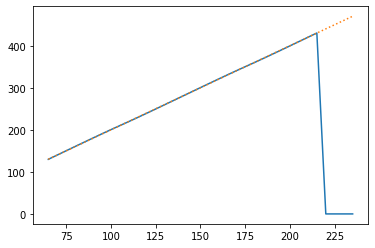

In [7]:
plt.figure()
plt.plot(fs, ps)
plt.plot(fs, 2*fs, linestyle=":")

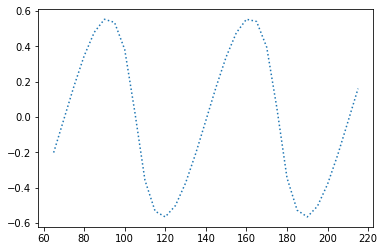

In [8]:
plt.plot(fs[:-4], ps[:-4]-2*fs[:-4], linestyle=":")